In [4]:
# Packages
from ovito.io import *
from ovito.modifiers import *
from ovito.pipeline import *

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [5]:
# Functions

def sigmoid(x, x0, k, a):
    y = 1 / (1 + np.exp(-k*(x-x0))) * a 
    return y


In [31]:
# Import data and loop through all frames
pipeline = import_file('/home/users/marthgg/simulation2/trajectory.bin', multiple_frames = True)

position_crack_tip = []
frames = []

extra_zeros = np.zeros((1))

#Initial guess for the sigmoidal function
#popt = [100]

for frame in range(7, pipeline.source.num_frames):
    
    # Affine transformation:
    pipeline.modifiers.append(AffineTransformationModifier(target_cell = [[1190.518, 0.0, 0.0, 10.005285762100016], [0.0, 82.7295483417, 0.0, 0.0], [0.0, 0.0, 108.52951440734999, -1.8350400986749946]], relative_mode = False, operate_on = {'voxels', 'dislocations', 'cell', 'vector_properties', 'surfaces'}))
    
    # Coordination analysis:
    pipeline.modifiers.append(CoordinationAnalysisModifier(number_of_bins = 100, partial = True))
    
    # Expression selection:
    pipeline.modifiers.append(ExpressionSelectionModifier(expression = 'Coordination>=4 || ParticleType==2'))
    
    # Delete selected:
    pipeline.modifiers.append(DeleteSelectedModifier())
    
    # Spatial binning:
    pipeline.modifiers.append(SpatialBinningModifier(property = 'Coordination', reduction_operation = SpatialBinningModifier.Operation.Sum, direction = SpatialBinningModifier.Direction.X, bin_count = (100, 200, 200)))

    data = pipeline.compute(frame)
    
    table = data.tables['binning'].xy()
        
    position_x   = table[:,0]
    coordination = table[:,1]
    
    increase_pos = position_x[1]-position_x[0]

    #position_x = np.insert(position_x, len(position_x), [position_x[-1]+increase_pos, position_x[-1]+increase_pos*2, position_x[-1]+increase_pos*3, position_x[-1]+increase_pos*4, position_x[-1]+increase_pos*5])
    #coordination = np.insert(coordination, len(coordination), extra_zeros)
    
    popt = [100]
    
    popt, pcov = curve_fit(sigmoid, position_x, coordination, p0=[popt[0], 0.001, (position_x[0]+position_x[-1])/2])

    sig_x = np.linspace(position_x[0], position_x[-1], len(position_x))
    sig_y = sigmoid(sig_x, *popt)
    
    #plt.figure()
    #plt.plot(position_x, coordination, label='data')
    #plt.plot(sig_x, sig_y, label='fit')
    #plt.legend()
    #plt.show()
    
    #print(popt[0])
    # if popt[0] > 2000:
        #print('Something wrong')
    #elif popt[0] < -100:
        #print('Something wrong')
    #else: 
    position_crack_tip.append(popt[0])
    frames.append(frame)
    
    if frame > 3:
        if np.abs(popt[0]-position_crack_tip[len(position_crack_tip)-2]) > 500:
            position_crack_tip.pop(-1)
            frames.pop(-1)

print(position_crack_tip)
print(len(position_crack_tip))

<ipython-input-5-11df9a8ae5a3>:4: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-k*(x-x0))) * a


[263.61642102700097, 282.3571360421802, 286.32077609122825, 289.13638514191604, 314.81622556731776, 350.90339674418766, 387.36889051767776, 422.41281594044705, 449.6708651471616, 494.2393950636499, 529.2717005713081, 565.7173855325948, 601.7985647826774, 639.2399589704878, 685.0837105829087, 722.3975898432659, 767.9286291373336, 798.60828926835, 834.3021255720674, 880.7012479683166, 922.839859962518, 958.3577846090487, 965.4917308395924, 966.0031255988387, 966.1270344725789, 965.2010003759244, 966.0773409355144, 962.8126169051307, 965.216530907743, 967.2300658815674, 966.6800340505969, 966.3769160821683, 963.6540349307094, 965.1054374121408, 961.4681880186508, 965.2256147453403, 965.7679306419185, 966.2146741579224, 964.9396631582536, 965.4364800847648, 964.8230520090456, 963.833908050807, 962.7722826625417, 966.5115822613225, 966.3544196657798, 963.0108581301699, 965.094008451147, 964.6033959234588, 962.4584651717555]
49


49


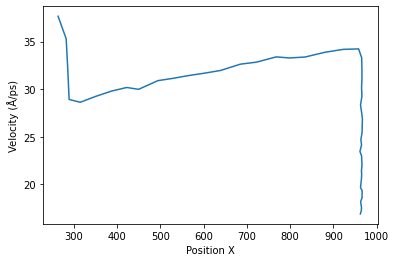

In [32]:
# Plot crack tip position with frame

velocity = []
print(len(frames))
for i in range(0, len(frames)):
    velocity.append(position_crack_tip[i]/frames[i])

plt.figure(1)
plt.plot(position_crack_tip, velocity)
plt.xlabel('Position X')
plt.ylabel('Velocity (Å/ps)')
plt.show()